# Visualizing Trajectories Tutorial


Rendering MiniGrid Trajectories is complicated by 3 details:
1. Minigrid rendering by default operates on the environment object, so only visualizes a state in time whereas we want to visualize a trajectory recording (recorded in the minigrid representation schema).
2. Our recording of observations may or may not be in 1 hot encoding. 
3. For debugging, we also want the agent's point of view. This would be kinda annoying for more generic troubleshooting (as the video would jump around a lot) so I've had to make some updates to enable this. 

All the code exists to do what we need and I'll organise it below.

## Default Full Observation Rendering

Let's start by demonstrating default rendering which you are probably already familiar with. We simply load an environment and render it using the render method. Calling render after each step will result in a video of the trajectory.


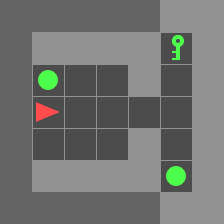

In [2]:
from src.environments.memory import MemoryEnv
from minigrid.wrappers import ViewSizeWrapper
import plotly.express as px 

env = MemoryEnv(size = 7, random_length=False, random_start_pos=False, max_steps=200, render_mode='rgb_array')
env.reset()
px.imshow(env.render()).show()


## Dense Scheme Observation Recording Rendering

Now let's load some trajectories. These trajectories were recorded in the dense schema (so not one hot encoded). We can see this in the shape of [7,7,3] and not [7,7,20]. (7 is the viewsize). @check if the trajectory file is in git.

In [3]:
import sys 
sys.path.append('..')
from src.decision_transformer.offline_dataset import TrajectoryDataset
path = "../trajectories/MiniGrid-MemoryS7FixedStart-v0-Checkpoint11.gz"
dataset = TrajectoryDataset(path, max_len = 10, prob_go_from_end=1)
s, a, r, d, rtg, ti, m = dataset[0]
s.shape

torch.Size([10, 7, 7, 3])

Note that dataset item 0 has observations with shape [10,7,7,3] so we have 10 steps in this trajectory loaded from the dataset. Like in language modelling, our datasets aren't parts of the original trajectory/sentence. So here we've got 10 frames from a trajectory. 

In [60]:
from src.visualization import render_minigrid_observation, render_minigrid_observations
import plotly.express as px
px.imshow(render_minigrid_observation(env, s[0])).show()

This frame shows nothing! That's because trajectories can be padded. Let's look at the padding mask, here called "m".

In [61]:
m 

tensor([False, False, False, False,  True,  True,  True,  True,  True,  True])

We can ignore the padding in practice and simply add a frame slider here for the trajectory. Moving the slider to frame 4 (the 5th frame) shows us this trajectory. 

In [62]:
px.imshow(render_minigrid_observations(env, s), animation_frame=0).show()

It seems like we're not seeing the observation after the last action which may matter. I'm not sure. 

### what am I doing under the hood? 

The functions I imported are in `src.visualization` and work by using the environments `env.grid.decode` method and `grid.render` methods. It's a bit messy but it works. 

## Sparse Schema / One Hot Encoding Observation Recording Rendering

Now let's do the same thing with one hot encoded trajectory (which I remember was a bit of a bitch to work out at some point in time). I'm going to be lazy here and use these trajectories with the "convert to one hot" utility that exists in `offline_dataset`. This function simply does the reverse of the minigrid one hot wrapper. 

In [63]:
from src.decision_transformer.offline_dataset import one_hot_encode_observation

one_hot_s = one_hot_encode_observation(s)
one_hot_s.shape

torch.Size([10, 7, 7, 20])

It's kinda embarassing how poorly organised this is but we have a "reverse one hot" function too. We should put this next to one_hot_encode... Anyway. Let's use `src.environments.utils.reverse_one_hot`

In [81]:
from src.environments.utils import reverse_one_hot
import numpy as np
import torch 

# switching from numpy to torch / back here is annoying. Maybe worth fixing. 
original_obs = torch.from_numpy(np.stack([reverse_one_hot(one_hot_s[i]) for i in range(one_hot_s.shape[0])]))
original_obs.shape == s.shape
assert torch.all(original_obs == s)

px.imshow(render_minigrid_observations(env, original_obs), animation_frame=0).show()

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
0
tensor([1.

Annnd that's it! Good luck!